# Quick Start

The notebook contains basic usage examples of NNDE. Also, running the whole notebook produces the figures included in the paper. 

## Installation

In [1]:
try:
    import NNDE
except:
    ! pip install -r requirements.txt
    ! pip install git+https://github.com/Karlmyh/NNDE.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Sampling Tools

In [3]:
###### generate samples with marginal density (Exp(0.5),Exp(0.5),Uniform(0,5))

from NNDE import ExponentialDistribution, UniformDistribution, MarginalDistribution

# setup
dim=3
density1 = ExponentialDistribution(lamda=0.5) 
density2 = UniformDistribution(low=0,upper=5) 

density_seq=[]
for i in range(dim-1):
    density_seq = density_seq+[density1]
density_seq=density_seq+[density2]

densitymarginal = MarginalDistribution(density_seq)


# generate 10 samples and return their pdf
samples,samples_pdf = densitymarginal.generate(10)
samples

array([[0.44352316, 0.12189143, 1.77182352],
       [0.26884541, 0.06582365, 4.52841806],
       [0.2132651 , 0.68149454, 4.84517582],
       [0.78234595, 1.21853882, 1.96071137],
       [0.57208766, 0.3826423 , 2.66112392],
       [0.60322492, 0.93889115, 2.28949547],
       [0.21060904, 0.82975586, 1.48889941],
       [0.61264037, 0.66451764, 2.8600756 ],
       [0.07635402, 0.10797204, 2.26597084],
       [0.96659849, 0.05829003, 1.39303999]])

In [4]:
# evaluate pdf at given samples
densitymarginal.density(samples)

# compare with true pdf
samples_pdf



array([0.25821241, 0.4096379 , 0.13363236, 0.01462661, 0.11852831,
       0.03661213, 0.09987126, 0.06219631, 0.55333279, 0.10301089])

array([0.25821241, 0.4096379 , 0.13363236, 0.01462661, 0.11852831,
       0.03661213, 0.09987126, 0.06219631, 0.55333279, 0.10301089])

In [5]:
###### generate samples with mixture density 0.4*Normal(1.5,0.05)+0.6*Normal(-1.5,0.3)

from NNDE import MultivariateNormalDistribution, MixedDistribution

# setup
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.05)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.3)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)

# generate 10 samples and return their pdf
samples, samples_pdf = densitymix.generate(10)
samples

array([[ 1.70511187,  1.21551103],
       [ 1.63353788,  1.37686691],
       [-1.60416121, -0.90350744],
       [-0.94605687, -0.82943924],
       [ 1.54363074,  1.35866285],
       [ 1.23053144,  1.56382645],
       [ 1.49876195,  1.41333254],
       [-1.79729197, -1.59278119],
       [-0.52913628, -0.993087  ],
       [ 1.37532498,  1.42970606]])

In [6]:
# evaluate pdf at given samples
densitymix.density(samples)

# compare with true pdf
samples_pdf



array([0.37214041, 0.91541593, 0.17276584, 0.09021396, 1.02302729,
       0.59137396, 1.18108872, 0.27079821, 0.0431118 , 1.03739575])

array([0.37214041, 0.91541593, 0.17276584, 0.09021396, 1.02302729,
       0.59137396, 1.18108872, 0.27079821, 0.0431118 , 1.03739575])

## Adaptive KD Tree

The Adaptive KD Tree is able to select largest k such that $R_k^{\beta}*k<C$ for given $\beta$ and $C$.

In [7]:
###### normal KDTree query as in sklearn

from NNDE import KDTree as AKDTree
X_train, _=densitymix.generate(1000)
X_test, _=densitymix.generate(4)


tree = AKDTree(X_train, leaf_size=2)              
dist, ind = tree.query(X_test, k=3)  

dist
ind

array([[0.01362475, 0.01718818, 0.01939459],
       [0.0462704 , 0.05375196, 0.12905609],
       [0.0738014 , 0.07751832, 0.09283965],
       [0.10549722, 0.11214511, 0.12145121]])

array([[533,  69, 153],
       [497, 162, 824],
       [ 64, 384, 575],
       [821, 735, 696]])

In [8]:
###### adaptive KDTree query 
    
dist, k = tree.adaptive_query(X_test, C=1, beta=1)  

# dist**beta * k should be close to but smaller than C=0.1 for all entries
dist*k

array([0.92288819, 0.91662397, 0.63791351, 0.92687696])

## NN Density Estimators

In [9]:
###### using AWNN to estimate density

from NNDE import AWNN

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# choose parameter C=0.1
model_AWNN=AWNN(C=.1).fit(X_train)
# output is log scaled
est_AWNN=np.exp(model_AWNN.predict(X_test))
# compute the mean absolute error
np.abs(est_AWNN-pdf_X_test).mean()


0.11005684610671009

In [10]:
###### using KNN to estimate density with k chosen by cross validation with respect to MISE criterion

from NNDE import KNN
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# select parameter grid
parameters={"k":[int(i*1000) for i in [0.01,0.02,0.05,0.1,0.2,0.5]]}
# use all available cpu, use 10 fold cross validation
cv_model_KNN=GridSearchCV(estimator=KNN(),param_grid=parameters,n_jobs=-1,cv=10)
_=cv_model_KNN.fit(X_train)
model_KNN=cv_model_KNN.best_estimator_
    
# output is log scaled
est_KNN=np.exp(model_KNN.predict(X_test))
# compute the mean absolute error
np.abs(est_KNN-pdf_X_test).mean()


0.05023861917053325

## Visualization

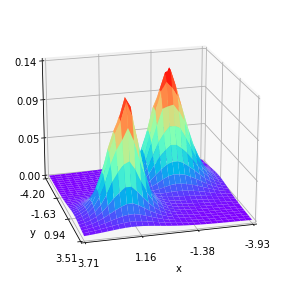

In [11]:
###### 3d prediction surface using WKNN

from NNDE import contour3d
from sklearn.model_selection import GridSearchCV

# generate samples
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour3d(X_train,method="WKNN",k=100)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_1.pdf",bbox_inches="tight",dpi=600)

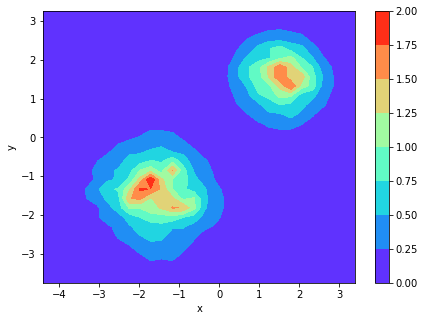

In [12]:
###### 2d prediction surface using BKNN

from NNDE import contour2d
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour2d(X_train,method="BKNN",C=10)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_2.pdf",bbox_inches="tight",dpi=600)


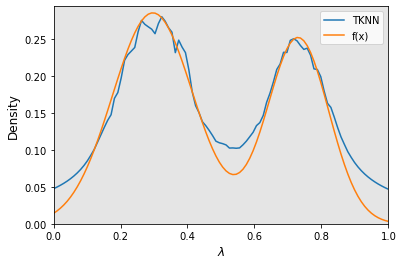

In [13]:
###### 1d prediction line plot using TKNN

from NNDE import lineplot
from sklearn.model_selection import GridSearchCV

# generate samples
dim=1
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)



model_plot=lineplot(X_train,method_seq=["TKNN"],true_density_obj=densitymix,kargs_seq=[{"k":150}])
fig=model_plot.plot()


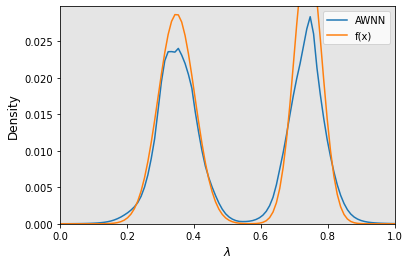

In [14]:
###### high dimensional sliced prediction line plot using AWNN
###### slicing is done


# generate samples
dim=4
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=lineplot(X_train,method_seq=["AWNN"],true_density_obj=densitymix,kargs_seq=[{"C":0.5}])
fig=model_plot.plot()



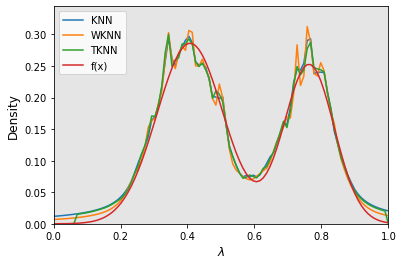

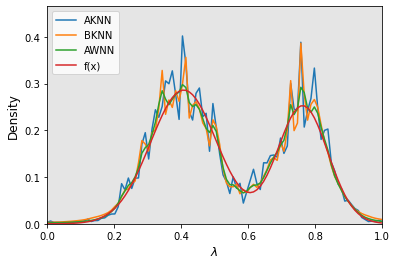

In [29]:
###### plot in the paper 

# generate samples
dim=1
np.random.seed(666)
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(2000)


kargs_seq= [{"k":110},{"k":100},{"k":100} ]
model_plot=lineplot(X_train,method_seq=["KNN", "WKNN", "TKNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_1.pdf",bbox_inches="tight",dpi=600)

kargs_seq= [{"C":0.5},{"C":1},{"C":0.5} ]
model_plot=lineplot(X_train,method_seq=["AKNN", "BKNN", "AWNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_2.pdf",bbox_inches="tight",dpi=600)

